# Sound celerity maps in the Gulf Stream area

This is a first exploration.
We focus on the global domain.


In [1]:
# import libraries

%matplotlib inline
from glob import glob
#from netCDF4 import Dataset
#import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gsw

from clib.flow import *

In [3]:
# load grid info
grd = grid()

# output files
ofiles = sorted(glob(grd._data_dir+'*avg*.nc'))
ofile = ofiles[0]

it = 0
ds = xr.open_dataset(ofile).isel(time=it)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070


---

## Temperature

To warm up we first look at temperature

---

In [4]:
# load temperature
T = ds['temp']
print(T)

<xarray.DataArray 'temp' (s_rho: 50, eta_rho: 1602, xi_rho: 2002)>
[160360200 values with dtype=float32]
Coordinates:
    time     float32 64802000.0
Dimensions without coordinates: s_rho, eta_rho, xi_rho
Attributes:
    long_name:      averaged potential temperature
    units:          Celsius
    field:          temperature, scalar, series
    standard_name:  sea_water_potential_temperature
    coordinates:    lat_rho lon_rho


---

## Horizontal map


Text(0.5,1,'surface temperature [degC]')

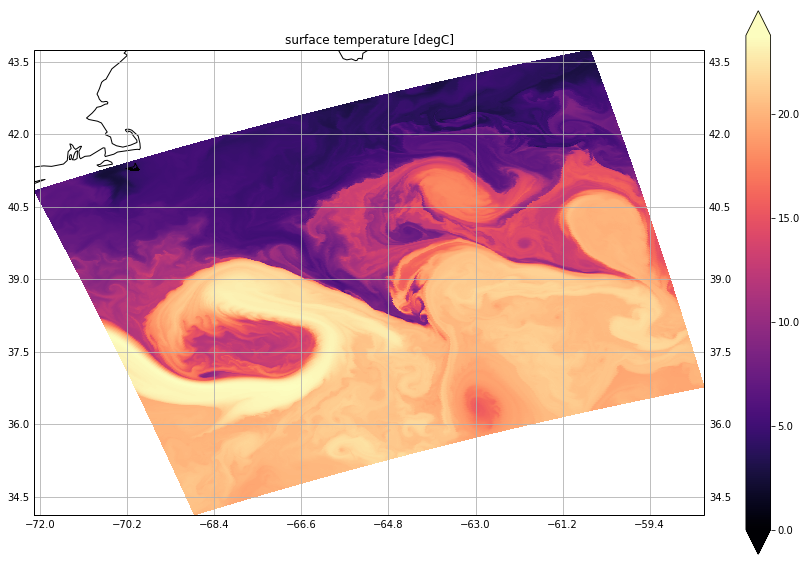

In [6]:
crs = ccrs.PlateCarree()

fig=plt.figure(figsize=(15,10))
#
ax=plt.axes(projection=crs)
ax.set_extent(grd.hextent, crs)
gl=ax.gridlines(crs=crs,draw_labels=True)
gl.xlabels_top = False
ax.coastlines(resolution='50m')
#
iz = -1
ilon = int(grd.Lp/2)  # used for vertical slices
toplt = T.isel(s_rho=iz)
# should probably mask T
cmap = plt.get_cmap('magma')
im = ax.pcolormesh(grd['lon_rho'],grd['lat_rho'],toplt,
                   vmin=toplt.min(),vmax=toplt.max(), 
                   cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_title('surface temperature [degC]')

#plt.savefig('figs/T_hmap.png',dpi=300)

---

## Vertical sections


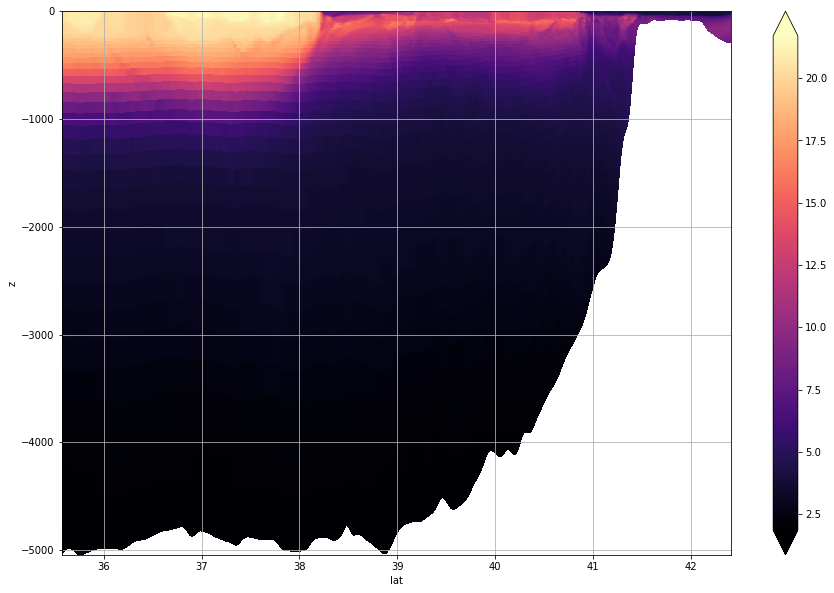

In [7]:
#ilon = grd.Lp/2
lat = grd['lat_rho'].isel(xi_rho = ilon)
h = grd['h'].isel(xi_rho=ilon)
zeta = ds['zeta'].isel(xi_rho = ilon)
z = grd.get_z(zeta, h)

plt.figure(figsize=(15,10))
ax=plt.subplot(111)
toplt = T.isel(xi_rho = ilon)
lat, z, toplt = xr.broadcast(lat, z, toplt)
im = ax.pcolormesh(lat, z, toplt, cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.grid(True)

#plt.savefig('figs/T_latz.png',dpi=300)


---

## Start looking at sound celerity now

---

In [15]:
# derive surface sound speed
S = ds['salt']
z = ds['temp'].isel(s_rho=-1) * 0.
c = get_soundc(T.isel(s_rho=-1), S.isel(s_rho=-1), z, grd['lon_rho'], grd['lat_rho'])

Text(0.5,1,'sound speed [m/s]')

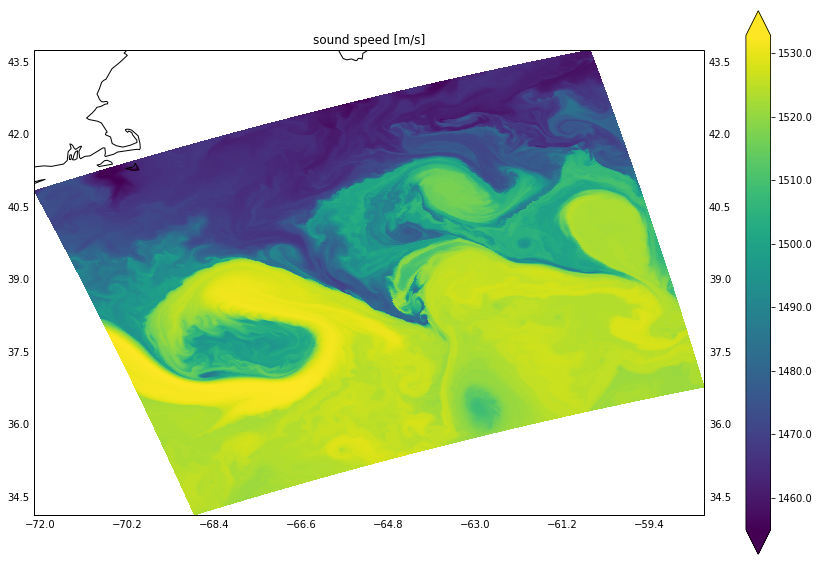

In [21]:
fig=plt.figure(figsize=(15,10))
#
ax=plt.axes(projection=crs)
ax.set_extent(grd.hextent, crs)
gl=ax.gridlines(crs=crs,draw_labels=True)
gl.xlabels_top = False
gl.xlines, gl.ylines = False, False
ax.coastlines(resolution='50m')
#
#it = 0
#iz = -1
#ilon = grd.Lp/2  # used for vertical slices
toplt = c
# should probably mask T
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(grd['lon_rho'],grd['lat_rho'],toplt,
                   vmin=1455, vmax=toplt.max(),    #toplt.min(),
                   cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_title('sound speed [m/s]')

#plt.savefig('figs/c_hmap.png',dpi=300)


---

### It is necessary to interpolate celerity on a single vertical grid

This is illustrated with the plot below which indicates variations of celerity at depth
that are not realistic.



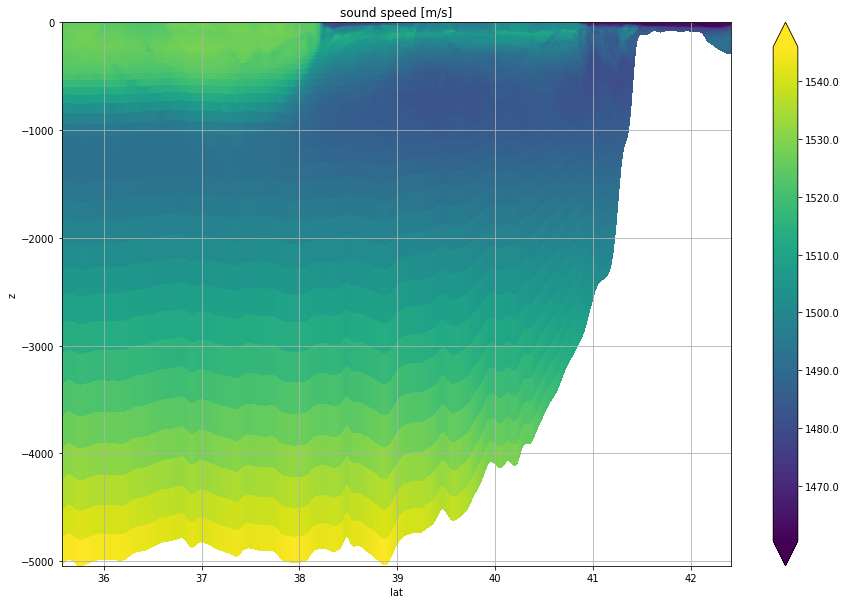

In [10]:
lon = grd['lon_rho'].isel(xi_rho=ilon)
lat = grd['lat_rho'].isel(xi_rho=ilon)
h = grd['h'].isel(xi_rho=ilon)
zeta = ds['zeta'].isel(xi_rho=ilon)
z = grd.get_z(zeta, h)
# derive surface sound speed
S = ds['salt']
c = get_soundc(T.isel(xi_rho=ilon).values, S.isel(xi_rho=ilon).values, 
               z.values, lon.values, lat.values)


plt.figure(figsize=(15,10))
ax=plt.subplot(111)
toplt = c
im = ax.pcolormesh(lat,z,toplt,cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.set_title('sound speed [m/s]')
ax.grid(True)

#plt.savefig('figs/T_latz.png',dpi=300)

---

Deep fluctuations of velocity disapear if temperature and salinity are first interpolated on a horizontal uniform vertical grid


In [11]:
lat.values[None,:].shape

(1, 1602)

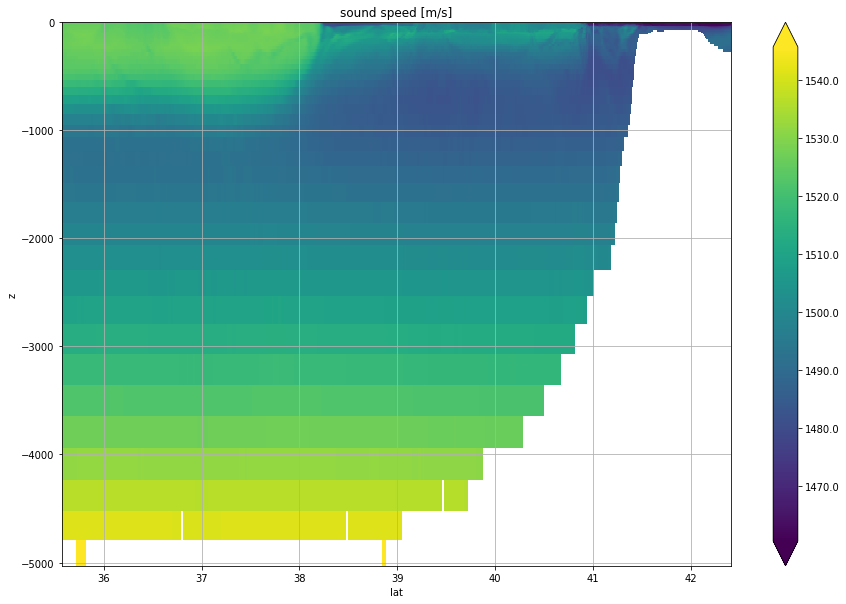

In [12]:
# interpolate on now a horizontally uniform grid

ilat=0
z_uni = z.isel(eta_rho=ilat).values
T_uni = interp2z(z_uni, z.values, T.isel(xi_rho=ilon).values)[:,:,0]
S_uni = interp2z(z_uni, z.values, S.isel(xi_rho=ilon).values)[:,:,0]
c_uni = get_soundc(T_uni, S_uni, z_uni[:,None], lon.values, lat.values)

plt.figure(figsize=(15,10))
ax=plt.subplot(111)
toplt = c_uni
im = ax.pcolormesh(lat,z_uni,toplt,cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.set_title('sound speed [m/s]')
ax.grid(True)


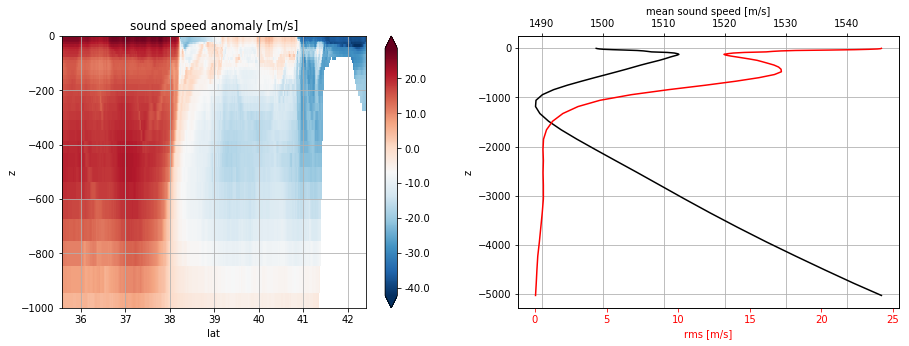

In [13]:
# show the anomaly with respect to the horizontally averaged profile

c_uni_mean = np.nanmean(c_uni,axis=1,keepdims=True)
c_uni_rms = np.nanstd(c_uni,axis=1,keepdims=True)

cmap = plt.get_cmap('RdBu_r')

plt.figure(figsize=(15,5))
ax=plt.subplot(121)
toplt = c_uni-c_uni_mean
im = ax.pcolormesh(lat,z_uni,toplt,cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.set_title('sound speed anomaly [m/s]')
ax.grid(True)
ax.set_ylim([-1000.,0.])

ax=plt.subplot(122)
ax.plot(c_uni_mean,z_uni,'k')
ax.set_ylabel('z')
#ax.set_title('sound speed, mean [m/s]')
ax.set_xlabel('mean sound speed [m/s]')
ax.grid(True)
ax.xaxis.set_label_position('top') 

ax2 = ax.twiny()
ax2.plot(c_uni_rms,z_uni,'r')
ax2.set_xlabel('rms [m/s]', color='r')
ax2.tick_params('x', colors='r')
ax2.xaxis.set_label_position('bottom') 
ax2.xaxis.tick_bottom()

ax.xaxis.tick_top()

#plt.savefig('figs/C_latz.png',dpi=300)

---

---

---